<a href="https://colab.research.google.com/github/temple17/self-review/blob/main/Chapter3_classification_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the data

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist["data"], mnist["target"]

X.shape
y.shape

(70000,)

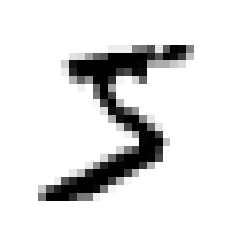

In [11]:
# all you need to do is grab an instance's feature vector, reshape it to a 28X28 array
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [12]:
y[0]

'5'

In [13]:
# the label is a string. so let's cast y to integer
import numpy as np
import pandas as pd
y = y.astype(np.uint8)

# Train set and test set

In [14]:
# The MNIST dataset is actually already split into a training set (the first 60,000 images)    
# and a test set (the last 10,000 images)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# the training set is already shuffled for us, which is good because this gurantees that  
# all cross-validation folds will be similar

# Training a Binary Classifier

In [15]:
# 5 and not-5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# start with SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [16]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measure

## Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5,
                         scoring = 'accuracy', cv = 3)

In [18]:
scores

array([0.9532 , 0.9546 , 0.96485])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [21]:
"""
This is simply because only about 10% of the images are 5s, so if you always
guess that an image is not a 5, you will ber right about 90% of the time.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers
"""

'\nThis is simply because only about 10% of the images are 5s, so if you always\nguess that an image is not a 5, you will ber right about 90% of the time.\nThis demonstrates why accuracy is generally not the preferred performance measure\nfor classifiers\n'

## Confusion-matrix

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3)

Just like the cross_val_score() function, cross_val_predict() performs    
K-fold cross_validation, but instead of returning the evaluation scores, it    
returns the predictions made on each test fold.

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53484,  1095],
       [ 1079,  4342]])

## Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7986021703145116

In [25]:
recall_score(y_train_5, y_train_pred)

0.8009592326139089

In [26]:
# combine recall and precision = > f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.799778964818567

In [27]:
y_scores = sgd_clf.decision_function([some_digit])

In [28]:
y_scores

array([2085.57531738])

In [30]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [32]:
threshhold = 8000
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([False])

### How do you decied which threshold to use
1. use the cross_val_predict() function to get the scores of all instances    
in the training set, but this time specify that you want  to return decision scores instead of predictions

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [44]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")

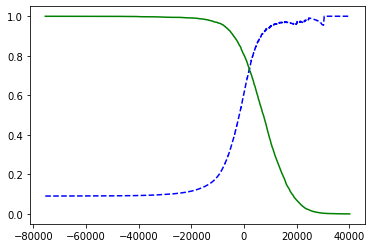

In [47]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)


In [48]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [49]:
threshold_90_precision

6519.593732862766

In [50]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [51]:
y_train_pred_90

array([ True, False, False, ...,  True, False, False])

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9001854140914709

In [54]:
recall_score(y_train_5, y_train_pred_90)

0.5373547315993359

## ROC Curve(Reciver operating characteristics curve

In [55]:
# TP vs FPR

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

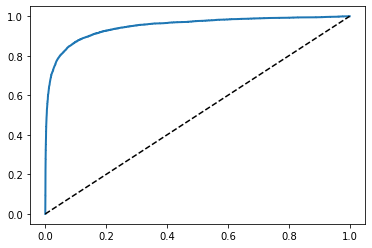

In [57]:
plot_roc_curve(fpr, tpr)

In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.94871358197596

# RandomForestClassifier

In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method ='predict_proba')

In [62]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

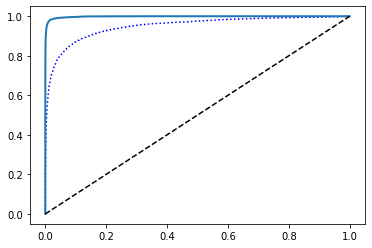

In [69]:
plt.plot(fpr, tpr, 'b:', label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")


In [71]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

### Summary
1. train binary classifier
2. choose appropriate metric
3. evaluate using cross_validation
4. precision/recall trade-off
5. ROC curve ROC AUC scores